In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 4
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

,Date,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
0,1/1/1979,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191
1,2/1/1979,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929
2,3/1/1979,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089
3,4/1/1979,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238
4,5/1/1979,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613


In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df.tail(len(df))

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
Date,,,,,,,,,,
1979-01-01,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191.0
1979-02-01,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929.0
1979-03-01,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089.0
1979-04-01,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238.0
1979-05-01,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613.0
...,...,...,...,...,...,...,...,...,...,...
2021-04-01,5.383687,1.529497,225.171796,156.567743,1.159049,0.929777,273.470298,263.146395,985.801841,13840000.0
2021-05-01,4.777020,2.451088,260.956781,229.604138,1.077705,0.575494,273.888627,271.557464,985.606182,12660000.0
2021-06-01,4.771453,4.176458,294.931709,244.702852,1.585094,0.360146,275.245088,278.360921,978.436682,10710000.0


In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

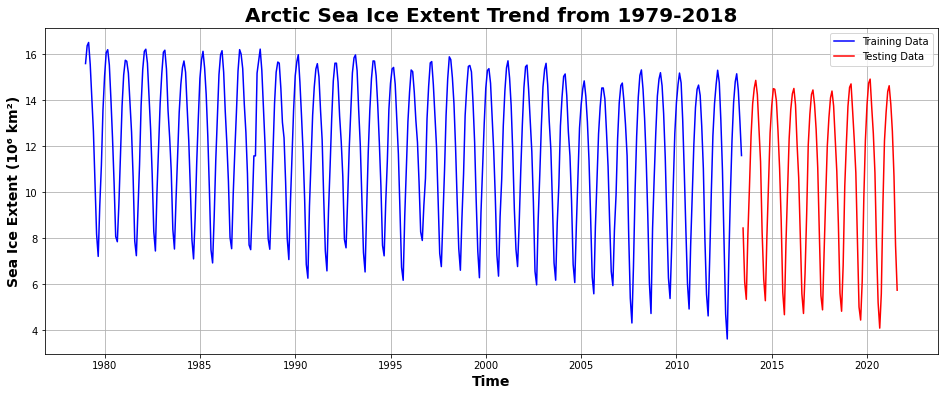

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6734 - mae: 0.6373 - mse: 0.6734

6/6 [==============================] - 20s 556ms/step - loss: 0.6267 - mae: 0.6094 - mse: 0.6267 - val_loss: 0.0972 - val_mae: 0.2811 - val_mse: 0.0972
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0831 - mae: 0.2408 - mse: 0.0831

6/6 [==============================] - 0s 63ms/step - loss: 0.0831 - mae: 0.2408 - mse: 0.0831 - val_loss: 0.0853 - val_mae: 0.2618 - val_mse: 0.0853
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0671 - mae: 0.2177 - mse: 0.0671

6/6 [==============================] - 0s 46ms/step - loss: 0.0655 - mae: 0.2143 - mse: 0.0655 - val_loss: 0.0889 - val_mae: 0.2343 - val_mse: 0.0889
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0837 - mae: 0.2250 - mse: 0.0837

6/6 [==============================] - 0s 47ms/step - loss: 0.0805 - mae: 0.2207 - mse: 0.0805 - val_loss: 0.0536 - val_mae: 0.2002 - val_mse: 0.0536
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0354 - mae: 0.1553 - mse: 0.0354

6/6 [==============================] - 0s 45ms/step - loss: 0.0352 - mae: 0.1546 - mse: 0.0352 - val_loss: 0.0806 - val_mae: 0.2474 - val_mse: 0.0806
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0197 - mae: 0.1099 - mse: 0.0197

6/6 [==============================] - 0s 48ms/step - loss: 0.0194 - mae: 0.1095 - mse: 0.0194 - val_loss: 0.0539 - val_mae: 0.2152 - val_mse: 0.0539
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0175 - mae: 0.1053 - mse: 0.0175

6/6 [==============================] - 0s 47ms/step - loss: 0.0176 - mae: 0.1061 - mse: 0.0176 - val_loss: 0.0151 - val_mae: 0.0985 - val_mse: 0.0151
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0148 - mae: 0.0966 - mse: 0.0148

6/6 [==============================] - 0s 47ms/step - loss: 0.0142 - mae: 0.0945 - mse: 0.0142 - val_loss: 0.0178 - val_mae: 0.1152 - val_mse: 0.0178
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0131 - mae: 0.0889 - mse: 0.0131

6/6 [==============================] - 0s 44ms/step - loss: 0.0135 - mae: 0.0906 - mse: 0.0135 - val_loss: 0.0190 - val_mae: 0.1207 - val_mse: 0.0190
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0101 - mae: 0.0809 - mse: 0.0101

6/6 [==============================] - 0s 47ms/step - loss: 0.0101 - mae: 0.0808 - mse: 0.0101 - val_loss: 0.0212 - val_mae: 0.1350 - val_mse: 0.0212
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0116 - mae: 0.0881 - mse: 0.0116

6/6 [==============================] - 0s 48ms/step - loss: 0.0114 - mae: 0.0875 - mse: 0.0114 - val_loss: 0.0109 - val_mae: 0.0821 - val_mse: 0.0109
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0106 - mae: 0.0818 - mse: 0.0106

6/6 [==============================] - 0s 50ms/step - loss: 0.0105 - mae: 0.0815 - mse: 0.0105 - val_loss: 0.0100 - val_mae: 0.0880 - val_mse: 0.0100
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0102 - mae: 0.0807 - mse: 0.0102

6/6 [==============================] - 0s 45ms/step - loss: 0.0099 - mae: 0.0792 - mse: 0.0099 - val_loss: 0.0100 - val_mae: 0.0728 - val_mse: 0.0100
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0091 - mae: 0.0727 - mse: 0.0091

6/6 [==============================] - 0s 48ms/step - loss: 0.0092 - mae: 0.0738 - mse: 0.0092 - val_loss: 0.0054 - val_mae: 0.0516 - val_mse: 0.0054
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0098 - mae: 0.0798 - mse: 0.0098

6/6 [==============================] - 0s 48ms/step - loss: 0.0097 - mae: 0.0793 - mse: 0.0097 - val_loss: 0.0077 - val_mae: 0.0745 - val_mse: 0.0077
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0114 - mae: 0.0854 - mse: 0.0114

6/6 [==============================] - 0s 47ms/step - loss: 0.0114 - mae: 0.0849 - mse: 0.0114 - val_loss: 0.0084 - val_mae: 0.0663 - val_mse: 0.0084
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0112 - mae: 0.0832 - mse: 0.0112

6/6 [==============================] - 0s 46ms/step - loss: 0.0108 - mae: 0.0816 - mse: 0.0108 - val_loss: 0.0075 - val_mae: 0.0677 - val_mse: 0.0075
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0105 - mae: 0.0826 - mse: 0.0105

6/6 [==============================] - 0s 47ms/step - loss: 0.0103 - mae: 0.0822 - mse: 0.0103 - val_loss: 0.0056 - val_mae: 0.0520 - val_mse: 0.0056
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0101 - mae: 0.0805 - mse: 0.0101

6/6 [==============================] - 0s 46ms/step - loss: 0.0101 - mae: 0.0805 - mse: 0.0101 - val_loss: 0.0058 - val_mae: 0.0556 - val_mse: 0.0058
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0085 - mae: 0.0733 - mse: 0.0085

6/6 [==============================] - 0s 47ms/step - loss: 0.0082 - mae: 0.0724 - mse: 0.0082 - val_loss: 0.0119 - val_mae: 0.0987 - val_mse: 0.0119
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0074 - mae: 0.0679 - mse: 0.0074

6/6 [==============================] - 0s 48ms/step - loss: 0.0075 - mae: 0.0686 - mse: 0.0075 - val_loss: 0.0097 - val_mae: 0.0897 - val_mse: 0.0097
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0073 - mae: 0.0706 - mse: 0.0073

6/6 [==============================] - 0s 46ms/step - loss: 0.0074 - mae: 0.0711 - mse: 0.0074 - val_loss: 0.0082 - val_mae: 0.0785 - val_mse: 0.0082
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0068 - mae: 0.0650 - mse: 0.0068

6/6 [==============================] - 0s 48ms/step - loss: 0.0067 - mae: 0.0647 - mse: 0.0067 - val_loss: 0.0055 - val_mae: 0.0570 - val_mse: 0.0055
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0611 - mse: 0.0058

6/6 [==============================] - 0s 50ms/step - loss: 0.0061 - mae: 0.0617 - mse: 0.0061 - val_loss: 0.0047 - val_mae: 0.0459 - val_mse: 0.0047
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0061 - mae: 0.0629 - mse: 0.0061

6/6 [==============================] - 0s 45ms/step - loss: 0.0062 - mae: 0.0630 - mse: 0.0062 - val_loss: 0.0048 - val_mae: 0.0463 - val_mse: 0.0048
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0560 - mse: 0.0051

6/6 [==============================] - 0s 47ms/step - loss: 0.0050 - mae: 0.0558 - mse: 0.0050 - val_loss: 0.0053 - val_mae: 0.0530 - val_mse: 0.0053
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0582 - mse: 0.0054

6/6 [==============================] - 0s 45ms/step - loss: 0.0056 - mae: 0.0589 - mse: 0.0056 - val_loss: 0.0039 - val_mae: 0.0428 - val_mse: 0.0039
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0594 - mse: 0.0056

6/6 [==============================] - 0s 47ms/step - loss: 0.0055 - mae: 0.0595 - mse: 0.0055 - val_loss: 0.0046 - val_mae: 0.0533 - val_mse: 0.0046
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0550 - mse: 0.0048

6/6 [==============================] - 0s 48ms/step - loss: 0.0047 - mae: 0.0548 - mse: 0.0047 - val_loss: 0.0062 - val_mae: 0.0640 - val_mse: 0.0062
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0059 - mae: 0.0616 - mse: 0.0059

6/6 [==============================] - 0s 47ms/step - loss: 0.0058 - mae: 0.0614 - mse: 0.0058 - val_loss: 0.0061 - val_mae: 0.0674 - val_mse: 0.0061
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0600 - mse: 0.0054

6/6 [==============================] - 0s 46ms/step - loss: 0.0053 - mae: 0.0596 - mse: 0.0053 - val_loss: 0.0052 - val_mae: 0.0511 - val_mse: 0.0052
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0052 - mae: 0.0569 - mse: 0.0052

6/6 [==============================] - 0s 44ms/step - loss: 0.0053 - mae: 0.0579 - mse: 0.0053 - val_loss: 0.0077 - val_mae: 0.0633 - val_mse: 0.0077
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0606 - mse: 0.0062

6/6 [==============================] - 0s 48ms/step - loss: 0.0064 - mae: 0.0619 - mse: 0.0064 - val_loss: 0.0055 - val_mae: 0.0508 - val_mse: 0.0055
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0063 - mae: 0.0638 - mse: 0.0063

6/6 [==============================] - 0s 47ms/step - loss: 0.0062 - mae: 0.0632 - mse: 0.0062 - val_loss: 0.0041 - val_mae: 0.0440 - val_mse: 0.0041
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0067 - mae: 0.0649 - mse: 0.0067

6/6 [==============================] - 0s 48ms/step - loss: 0.0065 - mae: 0.0644 - mse: 0.0065 - val_loss: 0.0102 - val_mae: 0.0770 - val_mse: 0.0102
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0066 - mae: 0.0655 - mse: 0.0066

6/6 [==============================] - 0s 47ms/step - loss: 0.0069 - mae: 0.0664 - mse: 0.0069 - val_loss: 0.0048 - val_mae: 0.0491 - val_mse: 0.0048
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0574 - mse: 0.0050

6/6 [==============================] - 0s 48ms/step - loss: 0.0050 - mae: 0.0570 - mse: 0.0050 - val_loss: 0.0086 - val_mae: 0.0722 - val_mse: 0.0086
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0550 - mse: 0.0049

6/6 [==============================] - 0s 47ms/step - loss: 0.0047 - mae: 0.0540 - mse: 0.0047 - val_loss: 0.0057 - val_mae: 0.0623 - val_mse: 0.0057
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0550 - mse: 0.0051

6/6 [==============================] - 0s 45ms/step - loss: 0.0049 - mae: 0.0544 - mse: 0.0049 - val_loss: 0.0061 - val_mae: 0.0600 - val_mse: 0.0061
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0055 - mae: 0.0582 - mse: 0.0055

6/6 [==============================] - 0s 46ms/step - loss: 0.0054 - mae: 0.0579 - mse: 0.0054 - val_loss: 0.0039 - val_mae: 0.0460 - val_mse: 0.0039
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0545 - mse: 0.0049

6/6 [==============================] - 0s 45ms/step - loss: 0.0048 - mae: 0.0540 - mse: 0.0048 - val_loss: 0.0062 - val_mae: 0.0566 - val_mse: 0.0062
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0539 - mse: 0.0048

6/6 [==============================] - 0s 46ms/step - loss: 0.0048 - mae: 0.0540 - mse: 0.0048 - val_loss: 0.0039 - val_mae: 0.0490 - val_mse: 0.0039
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0584 - mse: 0.0053

6/6 [==============================] - 0s 48ms/step - loss: 0.0056 - mae: 0.0597 - mse: 0.0056 - val_loss: 0.0046 - val_mae: 0.0586 - val_mse: 0.0046
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0063 - mae: 0.0633 - mse: 0.0063

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0619 - mse: 0.0060 - val_loss: 0.0041 - val_mae: 0.0543 - val_mse: 0.0041
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0594 - mse: 0.0056

6/6 [==============================] - 0s 47ms/step - loss: 0.0054 - mae: 0.0583 - mse: 0.0054 - val_loss: 0.0042 - val_mae: 0.0546 - val_mse: 0.0042
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0574 - mse: 0.0054

6/6 [==============================] - 0s 48ms/step - loss: 0.0052 - mae: 0.0568 - mse: 0.0052 - val_loss: 0.0075 - val_mae: 0.0616 - val_mse: 0.0075
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0562 - mse: 0.0048

6/6 [==============================] - 0s 46ms/step - loss: 0.0047 - mae: 0.0553 - mse: 0.0047 - val_loss: 0.0039 - val_mae: 0.0491 - val_mse: 0.0039
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0526 - mse: 0.0042

6/6 [==============================] - 0s 47ms/step - loss: 0.0043 - mae: 0.0534 - mse: 0.0043 - val_loss: 0.0057 - val_mae: 0.0596 - val_mse: 0.0057
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0470 - mse: 0.0034

6/6 [==============================] - 0s 45ms/step - loss: 0.0034 - mae: 0.0468 - mse: 0.0034 - val_loss: 0.0031 - val_mae: 0.0474 - val_mse: 0.0031
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0563 - mse: 0.0049

6/6 [==============================] - 0s 44ms/step - loss: 0.0048 - mae: 0.0556 - mse: 0.0048 - val_loss: 0.0021 - val_mae: 0.0334 - val_mse: 0.0021
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0534 - mse: 0.0043

6/6 [==============================] - 0s 49ms/step - loss: 0.0043 - mae: 0.0530 - mse: 0.0043 - val_loss: 0.0052 - val_mae: 0.0573 - val_mse: 0.0052
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0564 - mse: 0.0047

6/6 [==============================] - 0s 47ms/step - loss: 0.0050 - mae: 0.0575 - mse: 0.0050 - val_loss: 0.0033 - val_mae: 0.0394 - val_mse: 0.0033
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0563 - mse: 0.0050

6/6 [==============================] - 0s 49ms/step - loss: 0.0049 - mae: 0.0561 - mse: 0.0049 - val_loss: 0.0044 - val_mae: 0.0524 - val_mse: 0.0044
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0571 - mse: 0.0053

6/6 [==============================] - 0s 47ms/step - loss: 0.0050 - mae: 0.0558 - mse: 0.0050 - val_loss: 0.0082 - val_mae: 0.0669 - val_mse: 0.0082
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0513 - mse: 0.0041

6/6 [==============================] - 0s 48ms/step - loss: 0.0044 - mae: 0.0531 - mse: 0.0044 - val_loss: 0.0024 - val_mae: 0.0313 - val_mse: 0.0024
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0525 - mse: 0.0042

6/6 [==============================] - 0s 47ms/step - loss: 0.0042 - mae: 0.0521 - mse: 0.0042 - val_loss: 0.0048 - val_mae: 0.0499 - val_mse: 0.0048
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0523 - mse: 0.0044

6/6 [==============================] - 0s 48ms/step - loss: 0.0045 - mae: 0.0527 - mse: 0.0045 - val_loss: 0.0028 - val_mae: 0.0415 - val_mse: 0.0028
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0521 - mse: 0.0041

6/6 [==============================] - 0s 47ms/step - loss: 0.0041 - mae: 0.0519 - mse: 0.0041 - val_loss: 0.0030 - val_mae: 0.0391 - val_mse: 0.0030
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0458 - mse: 0.0032

6/6 [==============================] - 0s 47ms/step - loss: 0.0033 - mae: 0.0463 - mse: 0.0033 - val_loss: 0.0025 - val_mae: 0.0374 - val_mse: 0.0025
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0481 - mse: 0.0037

6/6 [==============================] - 0s 48ms/step - loss: 0.0037 - mae: 0.0481 - mse: 0.0037 - val_loss: 0.0013 - val_mae: 0.0264 - val_mse: 0.0013
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0460 - mse: 0.0034

6/6 [==============================] - 0s 47ms/step - loss: 0.0035 - mae: 0.0463 - mse: 0.0035 - val_loss: 0.0015 - val_mae: 0.0292 - val_mse: 0.0015
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0459 - mse: 0.0034

6/6 [==============================] - 0s 49ms/step - loss: 0.0035 - mae: 0.0466 - mse: 0.0035 - val_loss: 0.0032 - val_mae: 0.0419 - val_mse: 0.0032
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0457 - mse: 0.0033

6/6 [==============================] - 0s 46ms/step - loss: 0.0033 - mae: 0.0462 - mse: 0.0033 - val_loss: 0.0030 - val_mae: 0.0369 - val_mse: 0.0030
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0473 - mse: 0.0035

6/6 [==============================] - 0s 48ms/step - loss: 0.0035 - mae: 0.0468 - mse: 0.0035 - val_loss: 0.0025 - val_mae: 0.0353 - val_mse: 0.0025
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0407 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0027 - mae: 0.0406 - mse: 0.0027 - val_loss: 0.0029 - val_mae: 0.0405 - val_mse: 0.0029
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0430 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0424 - mse: 0.0029 - val_loss: 0.0029 - val_mae: 0.0423 - val_mse: 0.0029
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0465 - mse: 0.0034

6/6 [==============================] - 0s 47ms/step - loss: 0.0033 - mae: 0.0460 - mse: 0.0033 - val_loss: 0.0027 - val_mae: 0.0393 - val_mse: 0.0027
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0489 - mse: 0.0035

6/6 [==============================] - 0s 46ms/step - loss: 0.0035 - mae: 0.0487 - mse: 0.0035 - val_loss: 0.0018 - val_mae: 0.0300 - val_mse: 0.0018
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0473 - mse: 0.0035

6/6 [==============================] - 0s 45ms/step - loss: 0.0034 - mae: 0.0466 - mse: 0.0034 - val_loss: 0.0026 - val_mae: 0.0391 - val_mse: 0.0026
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0430 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0425 - mse: 0.0028 - val_loss: 0.0021 - val_mae: 0.0346 - val_mse: 0.0021
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0466 - mse: 0.0033

6/6 [==============================] - 0s 47ms/step - loss: 0.0033 - mae: 0.0463 - mse: 0.0033 - val_loss: 0.0040 - val_mae: 0.0507 - val_mse: 0.0040
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0435 - mse: 0.0029

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0440 - mse: 0.0030 - val_loss: 0.0039 - val_mae: 0.0424 - val_mse: 0.0039
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0467 - mse: 0.0035

6/6 [==============================] - 0s 47ms/step - loss: 0.0034 - mae: 0.0462 - mse: 0.0034 - val_loss: 0.0019 - val_mae: 0.0309 - val_mse: 0.0019
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0441 - mse: 0.0032

6/6 [==============================] - 0s 48ms/step - loss: 0.0032 - mae: 0.0440 - mse: 0.0032 - val_loss: 0.0034 - val_mae: 0.0429 - val_mse: 0.0034
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0433 - mse: 0.0029

6/6 [==============================] - 0s 49ms/step - loss: 0.0030 - mae: 0.0438 - mse: 0.0030 - val_loss: 0.0019 - val_mae: 0.0308 - val_mse: 0.0019
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0411 - mse: 0.0027

6/6 [==============================] - 0s 46ms/step - loss: 0.0027 - mae: 0.0413 - mse: 0.0027 - val_loss: 0.0038 - val_mae: 0.0505 - val_mse: 0.0038
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0478 - mse: 0.0036

6/6 [==============================] - 0s 47ms/step - loss: 0.0036 - mae: 0.0475 - mse: 0.0036 - val_loss: 0.0027 - val_mae: 0.0407 - val_mse: 0.0027
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0478 - mse: 0.0035

6/6 [==============================] - 0s 47ms/step - loss: 0.0033 - mae: 0.0464 - mse: 0.0033 - val_loss: 0.0038 - val_mae: 0.0471 - val_mse: 0.0038
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0416 - mse: 0.0027

6/6 [==============================] - 0s 48ms/step - loss: 0.0027 - mae: 0.0417 - mse: 0.0027 - val_loss: 0.0016 - val_mae: 0.0284 - val_mse: 0.0016
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0400 - mse: 0.0025

6/6 [==============================] - 0s 47ms/step - loss: 0.0025 - mae: 0.0397 - mse: 0.0025 - val_loss: 0.0031 - val_mae: 0.0435 - val_mse: 0.0031
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0436 - mse: 0.0031

6/6 [==============================] - 0s 48ms/step - loss: 0.0030 - mae: 0.0431 - mse: 0.0030 - val_loss: 0.0015 - val_mae: 0.0283 - val_mse: 0.0015
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0426 - mse: 0.0029

6/6 [==============================] - 0s 48ms/step - loss: 0.0029 - mae: 0.0429 - mse: 0.0029 - val_loss: 0.0039 - val_mae: 0.0488 - val_mse: 0.0039
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0450 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0030 - mae: 0.0445 - mse: 0.0030 - val_loss: 0.0015 - val_mae: 0.0297 - val_mse: 0.0015
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0424 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0423 - mse: 0.0028 - val_loss: 0.0060 - val_mae: 0.0552 - val_mse: 0.0060
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0465 - mse: 0.0033

6/6 [==============================] - 0s 48ms/step - loss: 0.0032 - mae: 0.0459 - mse: 0.0032 - val_loss: 0.0022 - val_mae: 0.0331 - val_mse: 0.0022
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0441 - mse: 0.0031

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0436 - mse: 0.0030 - val_loss: 0.0034 - val_mae: 0.0445 - val_mse: 0.0034
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0425 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0425 - mse: 0.0028 - val_loss: 0.0027 - val_mae: 0.0450 - val_mse: 0.0027
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0477 - mse: 0.0036

6/6 [==============================] - 0s 46ms/step - loss: 0.0035 - mae: 0.0472 - mse: 0.0035 - val_loss: 0.0027 - val_mae: 0.0426 - val_mse: 0.0027
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0406 - mse: 0.0028

6/6 [==============================] - 0s 45ms/step - loss: 0.0029 - mae: 0.0413 - mse: 0.0029 - val_loss: 0.0019 - val_mae: 0.0332 - val_mse: 0.0019
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0439 - mse: 0.0029

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0447 - mse: 0.0030 - val_loss: 0.0020 - val_mae: 0.0345 - val_mse: 0.0020
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0378 - mse: 0.0024

6/6 [==============================] - 0s 47ms/step - loss: 0.0024 - mae: 0.0384 - mse: 0.0024 - val_loss: 0.0031 - val_mae: 0.0443 - val_mse: 0.0031
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0405 - mse: 0.0026

6/6 [==============================] - 0s 47ms/step - loss: 0.0026 - mae: 0.0401 - mse: 0.0026 - val_loss: 0.0016 - val_mae: 0.0304 - val_mse: 0.0016
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0440 - mse: 0.0030

6/6 [==============================] - 0s 48ms/step - loss: 0.0031 - mae: 0.0450 - mse: 0.0031 - val_loss: 0.0027 - val_mae: 0.0403 - val_mse: 0.0027
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0392 - mse: 0.0025

6/6 [==============================] - 0s 45ms/step - loss: 0.0025 - mae: 0.0397 - mse: 0.0025 - val_loss: 0.0024 - val_mae: 0.0389 - val_mse: 0.0024
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0390 - mse: 0.0024

6/6 [==============================] - 0s 48ms/step - loss: 0.0025 - mae: 0.0394 - mse: 0.0025 - val_loss: 0.0023 - val_mae: 0.0371 - val_mse: 0.0023
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0401 - mse: 0.0025

6/6 [==============================] - 0s 48ms/step - loss: 0.0026 - mae: 0.0404 - mse: 0.0026 - val_loss: 0.0022 - val_mae: 0.0365 - val_mse: 0.0022
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0022 - mae: 0.0360 - mse: 0.0022

6/6 [==============================] - 0s 47ms/step - loss: 0.0022 - mae: 0.0362 - mse: 0.0022 - val_loss: 0.0015 - val_mae: 0.0303 - val_mse: 0.0015
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0023 - mae: 0.0381 - mse: 0.0023

6/6 [==============================] - 0s 47ms/step - loss: 0.0023 - mae: 0.0377 - mse: 0.0023 - val_loss: 0.0025 - val_mae: 0.0419 - val_mse: 0.0025
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0391 - mse: 0.0025

6/6 [==============================] - 0s 47ms/step - loss: 0.0025 - mae: 0.0395 - mse: 0.0025 - val_loss: 0.0039 - val_mae: 0.0543 - val_mse: 0.0039
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0473 - mse: 0.0035

6/6 [==============================] - 0s 47ms/step - loss: 0.0034 - mae: 0.0468 - mse: 0.0034 - val_loss: 0.0060 - val_mae: 0.0666 - val_mse: 0.0060


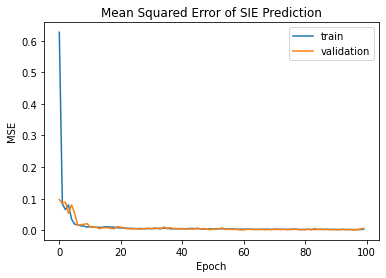

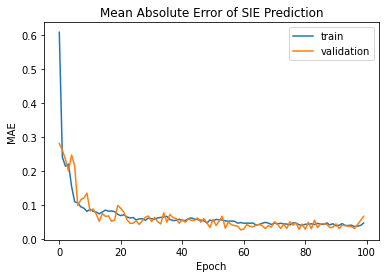

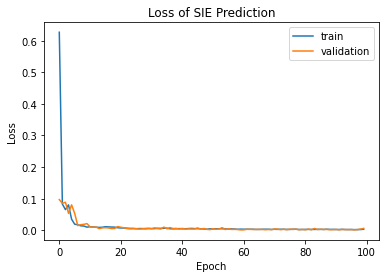

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 22ms/step


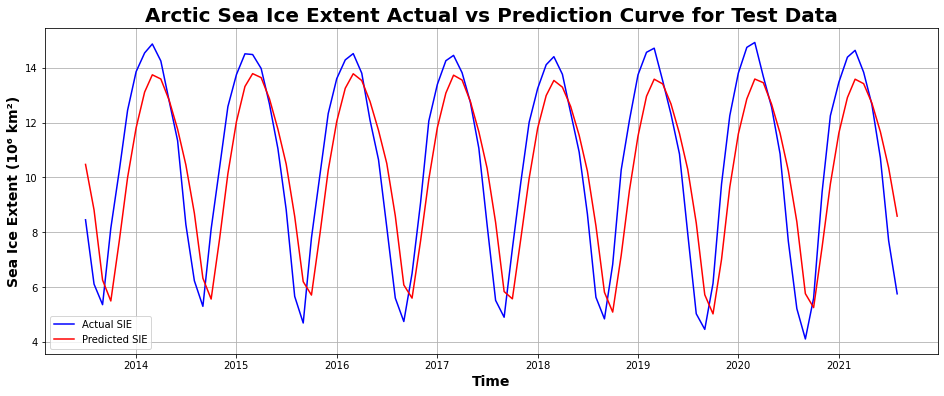

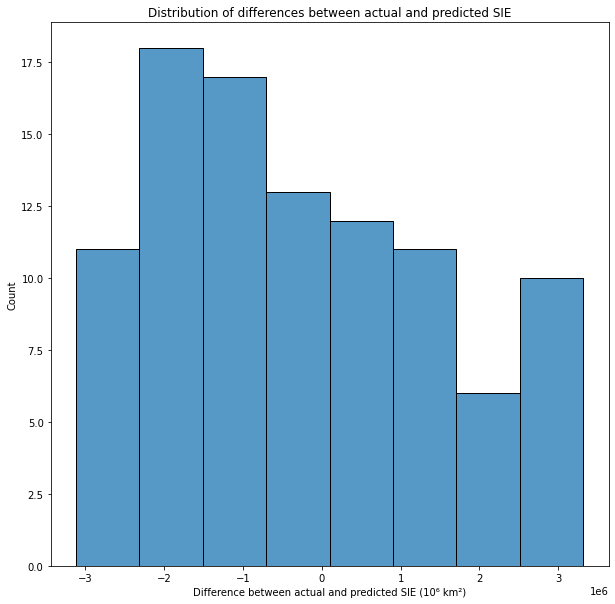

MSE :  3101899148538.967 (10⁶ km²)
MSPE : 5.293 %
RMSE :  1761220.925534036 (10⁶ km²)
RMSPE : 23.007 %
MAE :  1522103.7704081633 (10⁶ km²)
MAPE :  17.17 %
R2 :  59.275


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass